In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score, StratifiedKFold
import joblib

In [3]:
# Wczytanie danych
train_df = pd.read_csv('../data/preprocessed/decision_tree/train.csv')
test_df = pd.read_csv('../data/preprocessed/decision_tree/test.csv')

X_train = train_df.drop('Fault_Condition', axis=1)
y_train = train_df['Fault_Condition']
X_test = test_df.drop('Fault_Condition', axis=1)
y_test = test_df['Fault_Condition']

print(f'Train: {X_train.shape}, Test: {X_test.shape}')
print(f'Klasy: {y_train.value_counts().to_dict()}')

Train: (128, 26), Test: (56, 26)
Klasy: {'faulty_zip': 32, 'faulty': 32, 'healthy': 32, 'healthy_zip': 32}


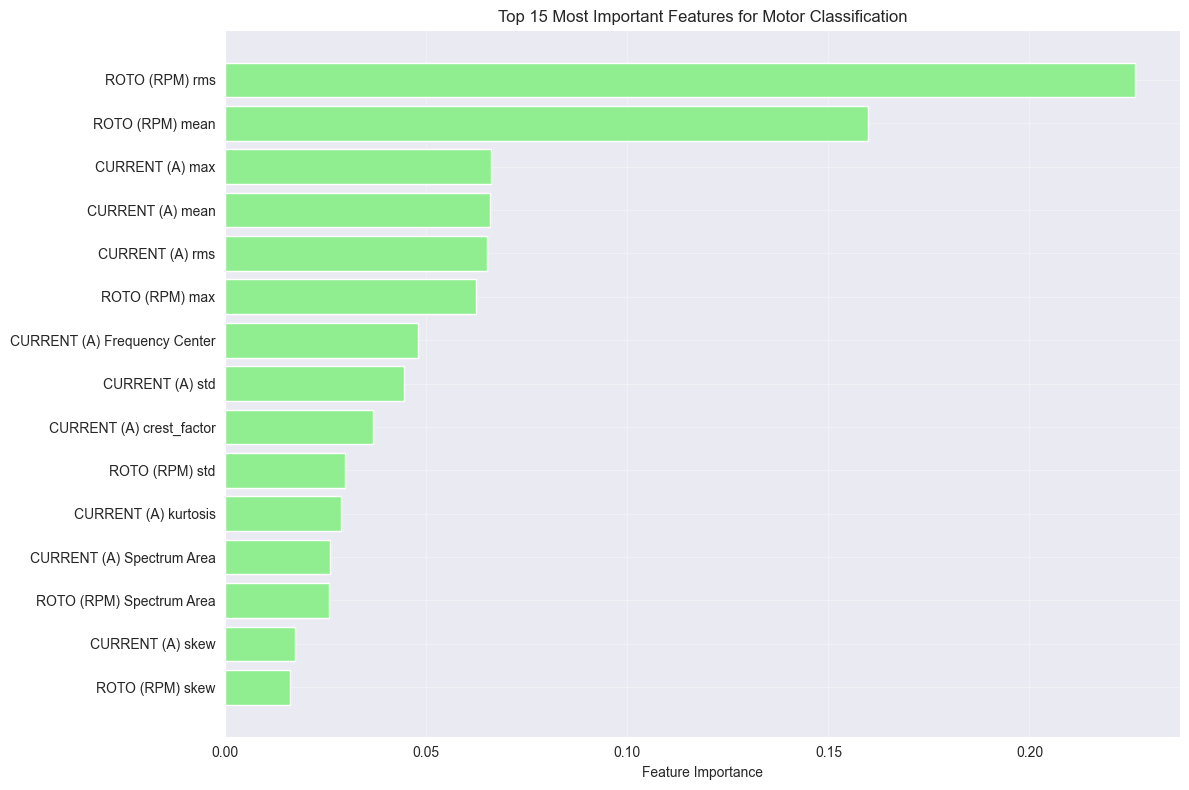

=== Top 10 Most Important Features ===
 1. ROTO (RPM) rms                 0.2261
 2. ROTO (RPM) mean                0.1598
 3. CURRENT (A) max                0.0662
 4. CURRENT (A) mean               0.0660
 5. CURRENT (A) rms                0.0652
 6. ROTO (RPM) max                 0.0623
 7. CURRENT (A) Frequency Center   0.0479
 8. CURRENT (A) std                0.0444
 9. CURRENT (A) crest_factor       0.0367
10. ROTO (RPM) std                 0.0297


In [4]:
# Analiza ważności cech - Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Ważność cech
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

# Top 15 najważniejszych cech
top_features = feature_importance.head(15)

plt.figure(figsize=(12, 8))
plt.barh(range(len(top_features)), top_features['importance'], color='lightgreen')
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Feature Importance')
plt.title('Top 15 Most Important Features for Motor Classification')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print('=== Top 10 Most Important Features ===')
for i, (_, row) in enumerate(top_features.head(10).iterrows()):
    print(f'{i+1:2d}. {row["feature"]:30s} {row["importance"]:.4f}')

=== Prior Probabilities ===
faulty: 0.2500
faulty_zip: 0.2500
healthy: 0.2500
healthy_zip: 0.2500


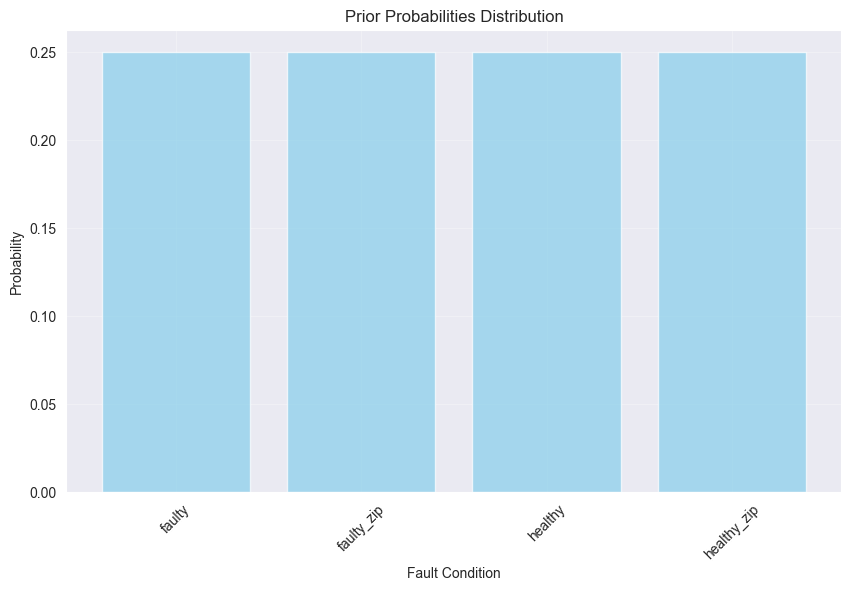

In [5]:
# Rozkłady priorów
prior_probs = y_train.value_counts(normalize=True).sort_index()
print('=== Prior Probabilities ===')
for class_name, prob in prior_probs.items():
    print(f'{class_name}: {prob:.4f}')

plt.figure(figsize=(10, 6))
plt.bar(prior_probs.index, prior_probs.values, alpha=0.7, color='skyblue')
plt.title('Prior Probabilities Distribution')
plt.xlabel('Fault Condition')
plt.ylabel('Probability')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.show()

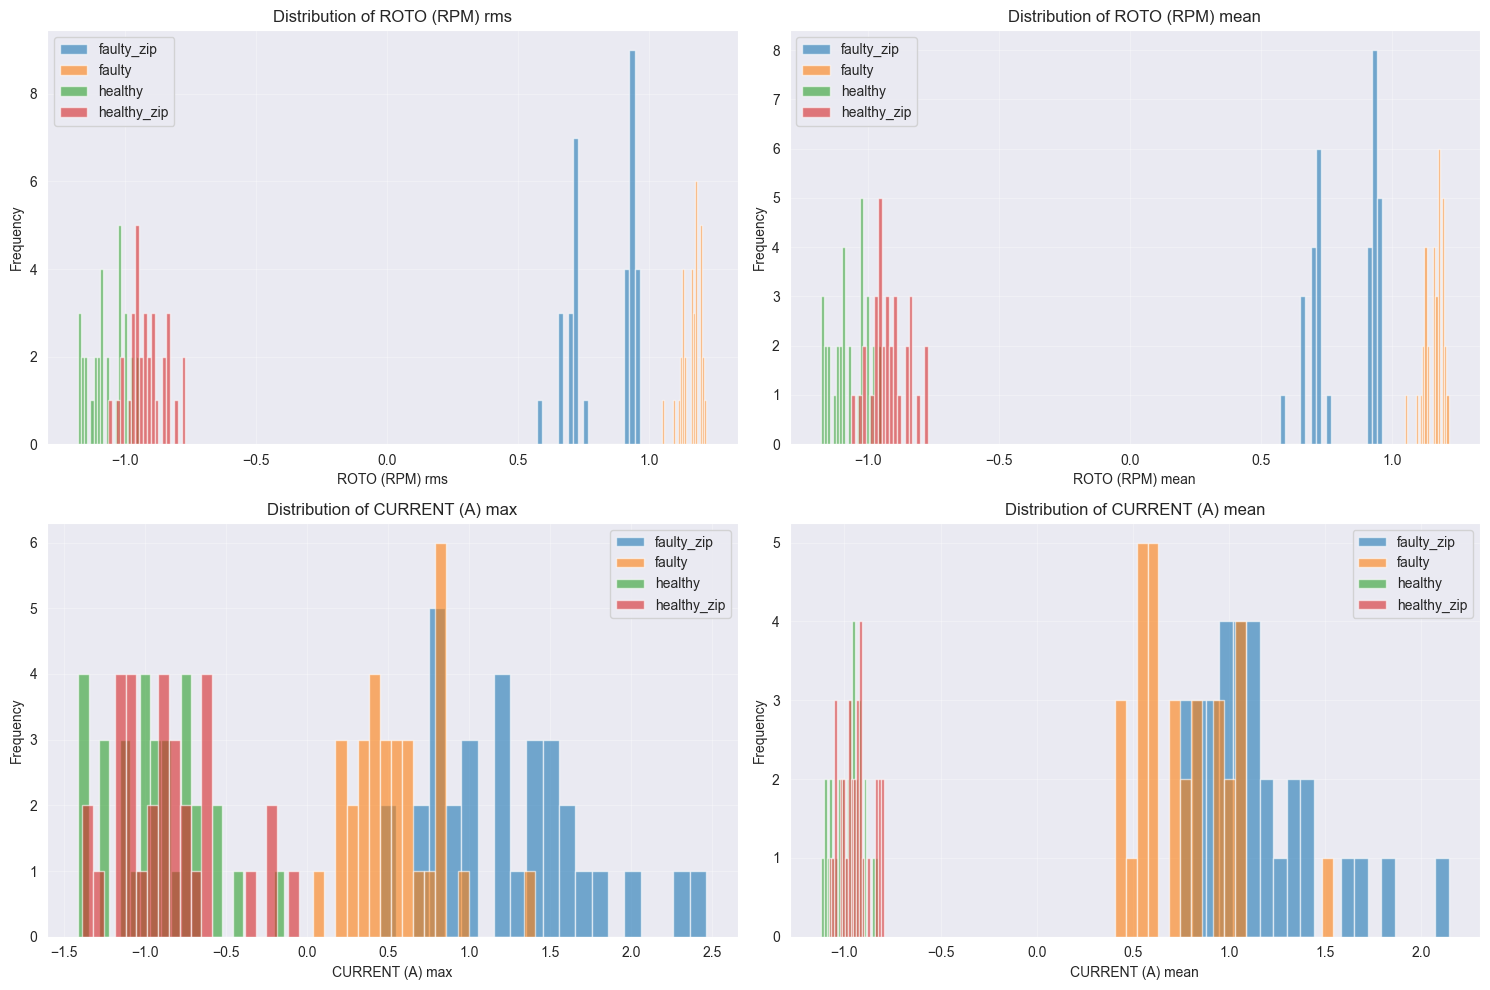

In [6]:
# Rozkłady najważniejszych cech dla każdej klasy
top_4_features = top_features.head(4)['feature'].values
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.ravel()

for i, feature in enumerate(top_4_features):
    for class_name in y_train.unique():
        class_data = X_train[y_train == class_name][feature]
        axes[i].hist(class_data, alpha=0.6, label=class_name, bins=20)
    axes[i].set_title(f'Distribution of {feature}')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Frequency')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

=== Gaussian Naive Bayes ===
Accuracy: 0.9464
              precision    recall  f1-score   support

      faulty       1.00      0.93      0.96        14
  faulty_zip       0.93      1.00      0.97        14
     healthy       1.00      0.86      0.92        14
 healthy_zip       0.88      1.00      0.93        14

    accuracy                           0.95        56
   macro avg       0.95      0.95      0.95        56
weighted avg       0.95      0.95      0.95        56



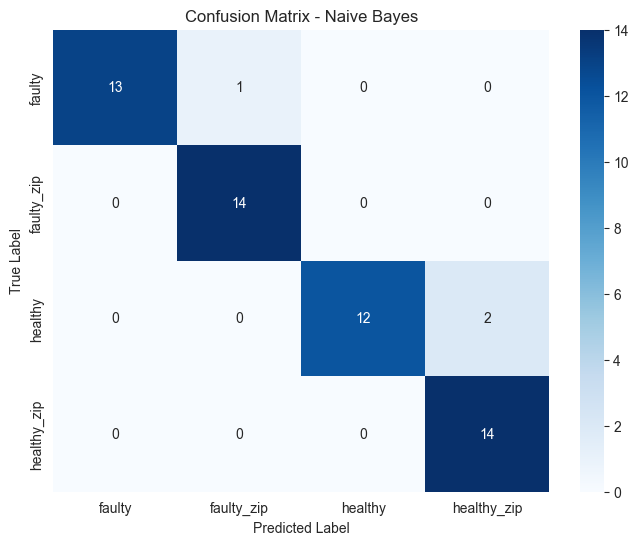

In [7]:
# Gaussian Naive Bayes
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)
nb_pred = nb_model.predict(X_test)

print('=== Gaussian Naive Bayes ===')
print(f'Accuracy: {accuracy_score(y_test, nb_pred):.4f}')
print(classification_report(y_test, nb_pred))

# Confusion Matrix
cm_nb = confusion_matrix(y_test, nb_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Blues', xticklabels=nb_model.classes_, yticklabels=nb_model.classes_)
plt.title('Confusion Matrix - Naive Bayes')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

=== Quadratic Discriminant Analysis ===
Accuracy: 0.9107
              precision    recall  f1-score   support

      faulty       1.00      1.00      1.00        14
  faulty_zip       1.00      1.00      1.00        14
     healthy       0.80      0.86      0.83        14
 healthy_zip       0.85      0.79      0.81        14

    accuracy                           0.91        56
   macro avg       0.91      0.91      0.91        56
weighted avg       0.91      0.91      0.91        56



C:\Users\norbo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
C:\Users\norbo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
C:\Users\norbo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 2 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
C:\Users\norbo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 3 is 

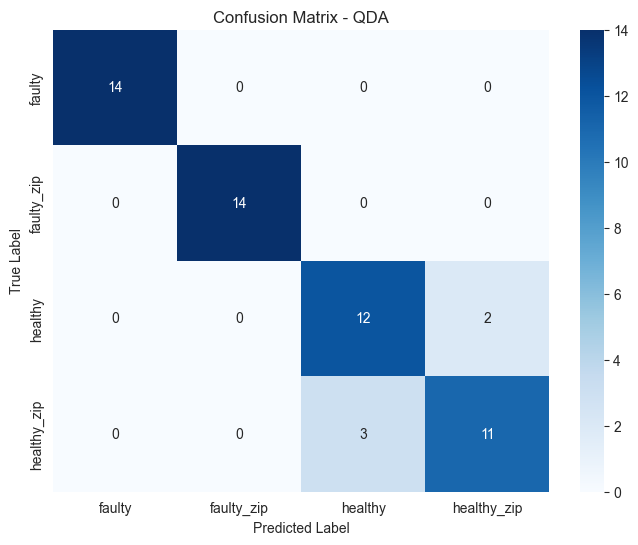

In [8]:
# Quadratic Discriminant Analysis
qda_model = QuadraticDiscriminantAnalysis()
qda_model.fit(X_train, y_train)
qda_pred = qda_model.predict(X_test)

print('=== Quadratic Discriminant Analysis ===')
print(f'Accuracy: {accuracy_score(y_test, qda_pred):.4f}')
print(classification_report(y_test, qda_pred))

# Confusion Matrix
cm_qda = confusion_matrix(y_test, qda_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_qda, annot=True, fmt='d', cmap='Blues', xticklabels=qda_model.classes_, yticklabels=qda_model.classes_)
plt.title('Confusion Matrix - QDA')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

=== Posterior Probabilities (first 5 samples) ===

Naive Bayes:
Sample 1: {'faulty': 1.5842835112943911e-34, 'faulty_zip': 1.0, 'healthy': 0.0, 'healthy_zip': 0.0}
Sample 2: {'faulty': 1.8200878779998807e-91, 'faulty_zip': 1.0, 'healthy': 0.0, 'healthy_zip': 0.0}
Sample 3: {'faulty': 0.0, 'faulty_zip': 3.450843244387581e-202, 'healthy': 0.999999908927404, 'healthy_zip': 9.107259613646848e-08}
Sample 4: {'faulty': 0.999999999770723, 'faulty_zip': 2.2927686930701525e-10, 'healthy': 0.0, 'healthy_zip': 0.0}
Sample 5: {'faulty': 0.999999999999929, 'faulty_zip': 7.182759118427136e-14, 'healthy': 0.0, 'healthy_zip': 0.0}

QDA:
Sample 1: {'faulty': 4.521360024927444e-267, 'faulty_zip': 1.0, 'healthy': 0.0, 'healthy_zip': 0.0}
Sample 2: {'faulty': 0.0, 'faulty_zip': 1.0, 'healthy': 0.0, 'healthy_zip': 0.0}
Sample 3: {'faulty': 0.0, 'faulty_zip': 0.0, 'healthy': 1.0, 'healthy_zip': 1.1682350686599083e-73}
Sample 4: {'faulty': 1.0, 'faulty_zip': 7.606280525482011e-70, 'healthy': 0.0, 'healthy_zi

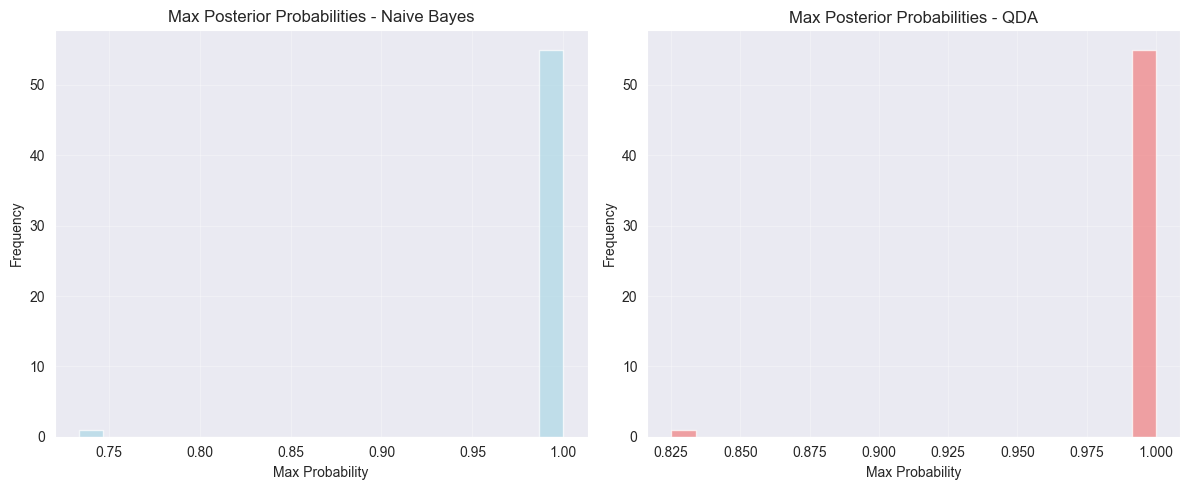

In [9]:
# Prawdopodobieństwa posteriori dla próbek testowych
nb_proba = nb_model.predict_proba(X_test)
qda_proba = qda_model.predict_proba(X_test)

# Przykładowe prawdopodobieństwa dla pierwszych 5 próbek
print('=== Posterior Probabilities (first 5 samples) ===')
print('\nNaive Bayes:')
for i in range(5):
    print(f'Sample {i+1}: {dict(zip(nb_model.classes_, nb_proba[i]))}')

print('\nQDA:')
for i in range(5):
    print(f'Sample {i+1}: {dict(zip(qda_model.classes_, qda_proba[i]))}')

# Rozkład maksymalnych prawdopodobieństw posteriori
max_proba_nb = np.max(nb_proba, axis=1)
max_proba_qda = np.max(qda_proba, axis=1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(max_proba_nb, bins=20, alpha=0.7, color='lightblue')
plt.title('Max Posterior Probabilities - Naive Bayes')
plt.xlabel('Max Probability')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.hist(max_proba_qda, bins=20, alpha=0.7, color='lightcoral')
plt.title('Max Posterior Probabilities - QDA')
plt.xlabel('Max Probability')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [10]:
# Cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

nb_cv_scores = cross_val_score(nb_model, X_train, y_train, cv=cv, scoring='accuracy')
qda_cv_scores = cross_val_score(qda_model, X_train, y_train, cv=cv, scoring='accuracy')

print('=== Cross-Validation Results ===')
print(f'Naive Bayes CV: {nb_cv_scores.mean():.4f} ± {nb_cv_scores.std():.4f}')
print(f'QDA CV: {qda_cv_scores.mean():.4f} ± {qda_cv_scores.std():.4f}')

=== Cross-Validation Results ===
Naive Bayes CV: 0.9212 ± 0.0501
QDA CV: 0.5249 ± 0.1001


C:\Users\norbo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
C:\Users\norbo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
C:\Users\norbo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 2 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
C:\Users\norbo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 3 is 

=== Model Comparison ===
         Model  Test Accuracy   CV Mean    CV Std
0  Naive Bayes       0.946429  0.921231  0.050140
1          QDA       0.910714  0.524923  0.100132


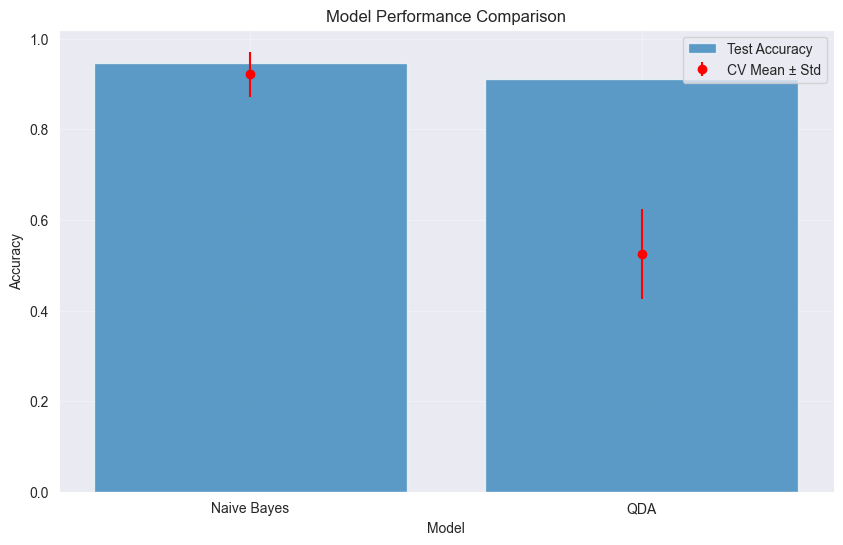

In [11]:
# Porównanie modeli
nb_acc = accuracy_score(y_test, nb_pred)
qda_acc = accuracy_score(y_test, qda_pred)

results_df = pd.DataFrame({
    'Model': ['Naive Bayes', 'QDA'],
    'Test Accuracy': [nb_acc, qda_acc],
    'CV Mean': [nb_cv_scores.mean(), qda_cv_scores.mean()],
    'CV Std': [nb_cv_scores.std(), qda_cv_scores.std()]
})

print('=== Model Comparison ===')
print(results_df)

# Wykres porównawczy
plt.figure(figsize=(10, 6))
x = np.arange(len(results_df))
plt.bar(x, results_df['Test Accuracy'], alpha=0.7, label='Test Accuracy')
plt.errorbar(x, results_df['CV Mean'], yerr=results_df['CV Std'], fmt='o', color='red', label='CV Mean ± Std')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Model Performance Comparison')
plt.xticks(x, results_df['Model'])
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [12]:
import pymc as pm
import pytensor.tensor as pt
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

# ---- Dane ----
scaler = StandardScaler()
X_train_np = scaler.fit_transform(X_train.values)
y_train_codes, y_map = pd.factorize(y_train)

n_samples, n_features = X_train_np.shape
n_classes = len(np.unique(y_train_codes))

X_test_np = X_test.values
y_test_codes = pd.Categorical(y_test, categories=y_map).codes

# ---- MODEL ----
with pm.Model() as model:

    # Priory globalne
    mu_w = pm.Normal("mu_w", 0, 0.5)
    sigma_w = pm.Exponential("sigma_w", 2)

    mu_b = pm.Normal("mu_b", 0, 0.5)
    sigma_b = pm.Exponential("sigma_b", 2)

    # Hierarchiczne wagi
    W = pm.Normal("W", mu=mu_w, sigma=sigma_w, shape=(n_features, n_classes))
    b = pm.Normal("b", mu=mu_b, sigma=sigma_b, shape=(n_classes,))

    # Logity
    logits = pt.dot(X_train_np, W) + b

    # Likelihood
    y_obs = pm.Categorical(
        "y_obs",
        p=pm.math.softmax(logits, axis=1),
        observed=y_train_codes
    )

    trace = pm.sample(
        100,
        tune=100,
        target_accept=0.9
    )


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_w, sigma_w, mu_b, sigma_b, W, b]


C:\Users\norbo\AppData\Local\Programs\Python\Python311\Lib\site-packages\rich\live.py:256: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 100 tune and 100 draw iterations (400 + 400 draws total) took 535 seconds.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [16]:
import numpy as np

# 1. Pobranie mean posterior z wag i biasów
W_mean = trace.posterior["W"].mean(dim=("chain", "draw")).values
b_mean = trace.posterior["b"].mean(dim=("chain", "draw")).values

# 2. Przeliczenie logitów
logits_test = X_test_np @ W_mean + b_mean

# 3. Softmax
probs_test = np.exp(logits_test) / np.exp(logits_test).sum(axis=1, keepdims=True)

# 4. Predykcja klasy
y_pred = probs_test.argmax(axis=1)

# 5. Mapowanie klas
y_pred_labels = y_map[y_pred]

print(y_pred_labels[:10])


Index(['faulty_zip', 'faulty_zip', 'healthy', 'faulty', 'faulty',
       'healthy_zip', 'faulty_zip', 'healthy', 'healthy_zip', 'faulty_zip'],
      dtype='object')


In [17]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred_labels))


              precision    recall  f1-score   support

      faulty       0.92      0.86      0.89        14
  faulty_zip       0.87      0.93      0.90        14
     healthy       0.93      0.93      0.93        14
 healthy_zip       0.93      0.93      0.93        14

    accuracy                           0.91        56
   macro avg       0.91      0.91      0.91        56
weighted avg       0.91      0.91      0.91        56



,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_w,0.173,0.562,-0.935,1.107,0.137,0.068,17.0,40.0,1.17
sigma_w,1.098,0.346,0.610,1.729,0.117,0.029,9.0,93.0,1.42
mu_b,-0.015,0.519,-0.975,0.915,0.025,0.023,428.0,374.0,1.01
sigma_b,0.601,0.513,0.049,1.532,0.059,0.055,62.0,114.0,1.04
"W[0, 0]",1.329,1.244,-0.963,3.853,0.108,0.110,138.0,296.0,1.05
...,...,...,...,...,...,...,...,...,...
"W[25, 3]",0.345,1.011,-1.407,2.249,0.091,0.064,122.0,176.0,1.02
b[0],0.026,0.798,-1.475,1.575,0.034,0.069,515.0,286.0,1.03
b[1],-0.104,0.919,-1.503,1.762,0.040,0.107,433.0,254.0,1.01
b[2],-0.318,0.942,-2.269,1.186,0.061,0.085,323.0,211.0,1.01


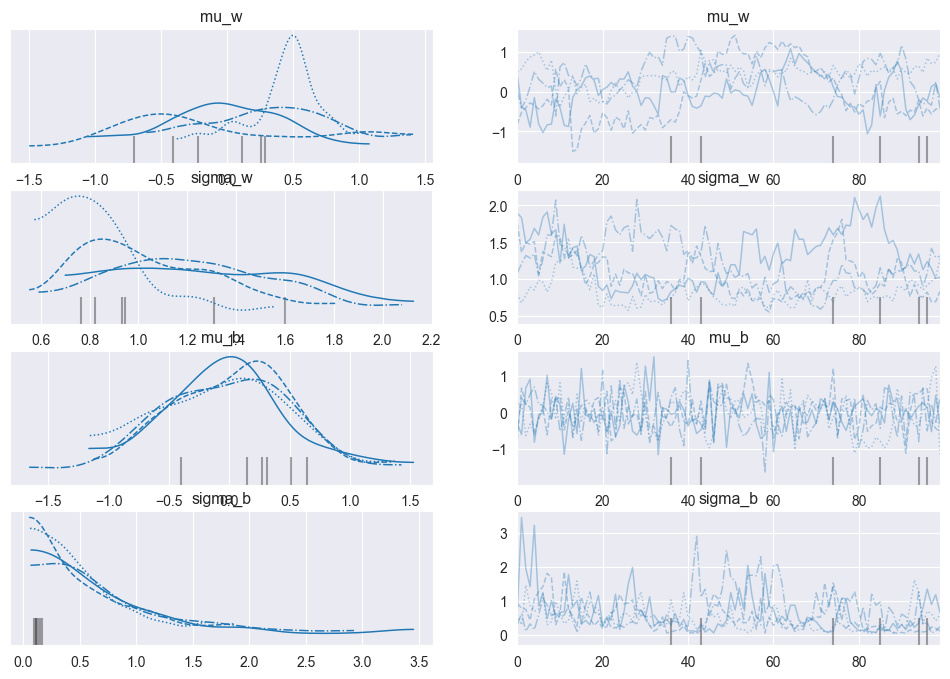

In [18]:
import arviz as az

az.plot_trace(trace, var_names=["mu_w", "sigma_w", "mu_b", "sigma_b"])
az.summary(trace, var_names=["mu_w", "sigma_w", "mu_b", "sigma_b", "W", "b"])


In [13]:
# Zapisanie najlepszego modelu
if qda_acc > nb_acc:
    joblib.dump(qda_model, 'QDA_motor_classifier.pkl')
    print(f'Zapisano QDA model (accuracy: {qda_acc:.4f})')
else:
    joblib.dump(nb_model, 'NaiveBayes_motor_classifier.pkl')
    print(f'Zapisano Naive Bayes model (accuracy: {nb_acc:.4f})')

Zapisano Naive Bayes model (accuracy: 0.9464)
